In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load embeddings
with open('distillBERT_embeddings_paragraph.json') as f:
    all_embeddings = json.load(f)

In [3]:
# show the shape of the embeddings
print('Shape of the embeddings: ', np.array(all_embeddings[0]).shape)

Shape of the embeddings:  (768,)


In [4]:
dtypes = {'cfips': str}
df = pd.read_csv('gpt_pro_con_no_null.csv', dtype=dtypes)

def read_csv_to_sentences(df):
    docs = []
    for i in range(len(df)):
        docs.append('PRO_1: ' + df['gpt_pro_1'][i] + 
                    ' PRO_2: ' + df['gpt_pro_2'][i] +
                    ' PRO_3: ' + df['gpt_pro_3'][i] +
                    ' CON_1: ' + df['gpt_con_1'][i] +
                    ' CON_2: ' + df['gpt_con_2'][i] +
                    ' CON_3: ' + df['gpt_con_3'][i])
    return docs

docs = read_csv_to_sentences(df)
final_sentences = docs
final_embeddings = all_embeddings


In [5]:
# train test split
from sklearn.model_selection import train_test_split

emb_train, emb_test, sent_train, sent_test = train_test_split(final_embeddings, 
                                                                final_sentences, 
                                                                test_size=0.2, 
                                                                random_state=42)

In [6]:
# Autoencoder class
class AE(torch.nn.Module):
	def __init__(self, encode_dim):
		super().__init__()
		
		self.encode_dim = encode_dim
		# 768 ==> encode_dim
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(768, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, self.encode_dim)
		)
		
		# encode_dim ==> 768
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(self.encode_dim, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 768),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded, encoded
	
	def encode(self, x):
		return self.encoder(x)


In [7]:
# define a loader for the embeddings
from torch.utils.data import TensorDataset, DataLoader

embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)

# convert the embeddings to tensors, in all dimensions
emb_train_tensor = torch.tensor(emb_train, dtype=torch.float32)
emb_test_tensor = torch.tensor(emb_test, dtype=torch.float32)

# create a dataset
train_dataset = TensorDataset(emb_train_tensor)
test_dataset = TensorDataset(emb_test_tensor)

# create a loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [8]:
def train_model(train_loader, eval_loader, model, loss_function, optimizer, 
				epochs=10, print_every=5, if_print=True):

	train_losses = []
	valid_losses = []
	epoch_record = []
	for epoch in range(epochs):
		if epoch % print_every == 0:
			epoch_record.append(epoch)
			print('epoch: ', epoch)
		curr_train_losses = []
		curr_valid_losses = []

		model.train()
		for emb in train_loader:
			emb = emb[0]
			reconstructed, encoded = model(emb)
			loss = loss_function(reconstructed, emb, encoded)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			np_loss = loss.detach().numpy()
			curr_train_losses.append(np_loss.mean())

		model.eval()
		for emb in eval_loader:
			emb = emb[0]
			reconstructed, encoded = model(emb)
			loss = loss_function(reconstructed, emb, encoded)
			np_loss = loss.detach().numpy()
			curr_valid_losses.append(np_loss)

		if epoch % print_every == 0:
			print('train loss: ', np.mean(curr_train_losses))
			print('valid loss: ', np.mean(curr_valid_losses))
		train_losses.append(np.mean(curr_train_losses))
		valid_losses.append(np.mean(curr_valid_losses))

	
	if if_print:
		plot_last = 13
		# plot the losses
		plt.style.use('fivethirtyeight')
		plt.xlabel('Iterations')
		plt.ylabel('Loss')
		plt.title('Loss vs. Iterations')
		plt.plot(epoch_record[-plot_last:], train_losses[-plot_last:], label='Training Loss', color='blue')
		plt.plot(epoch_record[-plot_last:], valid_losses[-plot_last:], label='Validation Loss', color='red')
		plt.legend()
		plt.show()
	else:
		return model


epoch:  0
train loss:  0.8176624
valid loss:  0.79539704
epoch:  3
train loss:  0.68523216
valid loss:  0.66263103
epoch:  6
train loss:  0.42223883
valid loss:  0.3915513
epoch:  9
train loss:  0.25408268
valid loss:  0.2283529
epoch:  12
train loss:  0.15329377
valid loss:  0.14258227
epoch:  15
train loss:  0.103880204
valid loss:  0.098363176
epoch:  18
train loss:  0.08057862
valid loss:  0.07823256
epoch:  21
train loss:  0.06963388
valid loss:  0.068434566
epoch:  24
train loss:  0.06432177
valid loss:  0.06373198
epoch:  27
train loss:  0.061184485
valid loss:  0.06077514
epoch:  30
train loss:  0.0593306
valid loss:  0.05904587
epoch:  33
train loss:  0.05819928
valid loss:  0.0579502
epoch:  36
train loss:  0.0573246
valid loss:  0.058114804
epoch:  39
train loss:  0.056592118
valid loss:  0.056719262
epoch:  42
train loss:  0.056209195
valid loss:  0.056158762
epoch:  45
train loss:  0.055997044
valid loss:  0.05602727
epoch:  48
train loss:  0.05555574
valid loss:  0.055639

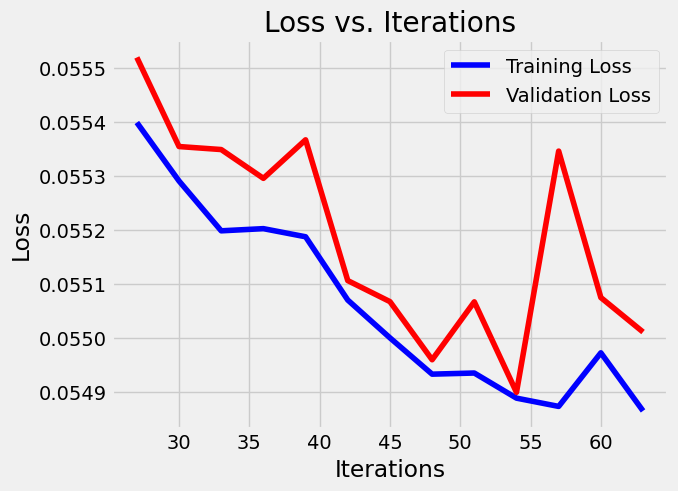

In [9]:
# set hyperparameters
EPOCHS = 65
LR = 5e-5
WEIGHT_DECAY = 1e-12
ENCODE_DIM = 10

# set the random seed
torch.manual_seed(42)

# Model Initialization
AE_model = AE(encode_dim=ENCODE_DIM)

# define the loss function with LASSO-ish regularization
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, output, target, encoded):
        criterion = nn.MSELoss()
        loss_part_1 = criterion(output, target)
        loss_part_2 = torch.sum(torch.abs(encoded)) * 0.01
        return loss_part_1 + loss_part_2

loss_function = loss_function()
 
posi_optimizer = torch.optim.Adam(AE_model.parameters(),
                                lr = LR,
                                weight_decay = WEIGHT_DECAY)

# train the model
train_model(train_loader, test_loader, AE_model, 
                loss_function, posi_optimizer, epochs=EPOCHS, print_every=3)

# 50 Epochs with selected hyperparameters looks good

epoch:  0
train loss:  0.8176624
valid loss:  0.79539704
epoch:  3
train loss:  0.68523216
valid loss:  0.66263103
epoch:  6
train loss:  0.42223883
valid loss:  0.3915513
epoch:  9
train loss:  0.25408268
valid loss:  0.2283529
epoch:  12
train loss:  0.15329377
valid loss:  0.14258227
epoch:  15
train loss:  0.103880204
valid loss:  0.098363176
epoch:  18
train loss:  0.08057862
valid loss:  0.07823256
epoch:  21
train loss:  0.06963388
valid loss:  0.068434566
epoch:  24
train loss:  0.06432177
valid loss:  0.06373198
epoch:  27
train loss:  0.061184485
valid loss:  0.06077514
epoch:  30
train loss:  0.0593306
valid loss:  0.05904587
epoch:  33
train loss:  0.05819928
valid loss:  0.0579502
epoch:  36
train loss:  0.0573246
valid loss:  0.058114804
epoch:  39
train loss:  0.056592118
valid loss:  0.056719262
epoch:  42
train loss:  0.056209195
valid loss:  0.056158762
epoch:  45
train loss:  0.055997044
valid loss:  0.05602727
epoch:  48
train loss:  0.05555574
valid loss:  0.055639

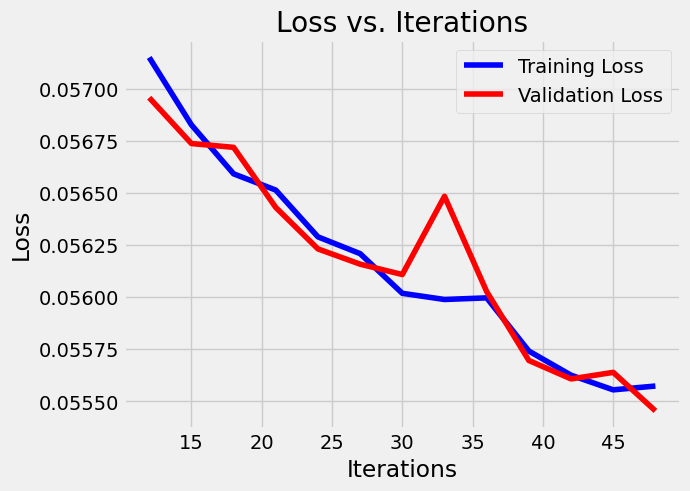

epoch:  0
train loss:  0.055401694
valid loss:  0.05554341
epoch:  10
train loss:  0.05493536
valid loss:  0.05506725
epoch:  20
train loss:  0.054647587
valid loss:  0.054698884
epoch:  30
train loss:  0.054512657
valid loss:  0.05460276
epoch:  40
train loss:  0.054344893
valid loss:  0.054657668


AE(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=768, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# train the model
# set hyperparameters
EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-12
ENCODE_DIM = 10

# set the random seed
torch.manual_seed(42)

# Model Initialization
AE_model = AE(encode_dim=ENCODE_DIM)

# define the loss function with LASSO-ish regularization
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, output, target, encoded):
        criterion = nn.MSELoss()
        loss_part_1 = criterion(output, target)
        loss_part_2 = torch.sum(torch.abs(encoded)) * 0.01
        return loss_part_1 + loss_part_2

loss_function = loss_function()
 
posi_optimizer = torch.optim.Adam(AE_model.parameters(),
                                lr = LR,
                                weight_decay = WEIGHT_DECAY)

# train the model
train_model(train_loader, test_loader, AE_model, 
                loss_function, posi_optimizer, epochs=EPOCHS, print_every=3)

final_model = train_model(train_loader, test_loader, AE_model, 
                            loss_function, posi_optimizer, epochs=EPOCHS, print_every=10, if_print=False)

final_model.eval()

In [11]:
# save the model
torch.save(AE_model.state_dict(), 'AE_model.pt')

In [12]:
# use model to encode the embeddings
gpt_encoded = AE_model.encoder(embeddings_tensor)
gpt_encoded_np = gpt_encoded.detach().numpy()

In [13]:
gpt_encoded_np.shape

(3142, 10)

In [14]:
gpt_encoded_np.shape[0]

3142

In [15]:
# load the cfips data
dtypes = {'cfips': str}
cfips_df = pd.read_csv('cfips.csv', dtype=dtypes)
cfips_df.head()

,cfips
0,01001
1,01003
2,01005
3,01007
4,01009


In [16]:
dim_names = ['AE_dim_' + str(i) for i in range(1, 11)]
dim_names

['AE_dim_1',
 'AE_dim_2',
 'AE_dim_3',
 'AE_dim_4',
 'AE_dim_5',
 'AE_dim_6',
 'AE_dim_7',
 'AE_dim_8',
 'AE_dim_9',
 'AE_dim_10']

In [17]:
AE_df = pd.DataFrame(columns=['cfips']+dim_names)
AE_df.head()

,cfips,AE_dim_1,AE_dim_2,AE_dim_3,AE_dim_4,AE_dim_5,AE_dim_6,AE_dim_7,AE_dim_8,AE_dim_9,AE_dim_10


In [18]:
for i, cfips_str in enumerate(cfips_df['cfips']):
    AE_df.loc[i, 'cfips'] = cfips_str
    AE_df.loc[i, dim_names] = gpt_encoded_np[i, :]
AE_df.head()

,cfips,AE_dim_1,AE_dim_2,AE_dim_3,AE_dim_4,AE_dim_5,AE_dim_6,AE_dim_7,AE_dim_8,AE_dim_9,AE_dim_10
0,01001,-0.00074,0.000235,0.000044,0.000279,0.0,0.000106,-0.000065,0.000241,-0.000282,-0.00073
1,01003,0.000354,-0.000244,-0.00005,-0.000005,-0.000135,-0.000333,0.000111,0.000104,0.000011,0.000164
2,01005,-0.000364,0.000122,0.000024,0.000149,-0.000167,-0.000023,0.000028,0.00004,-0.00008,-0.000505
3,01007,0.000009,-0.000197,0.000925,0.000245,-0.00039,-0.000478,0.000116,-0.000387,0.000032,0.000354
4,01009,-0.000177,-0.000038,0.000049,0.000193,-0.00021,-0.000325,-0.000021,0.000004,-0.000118,-0.000382


In [19]:
# save the AE_df to csv
AE_df.to_csv('AE_df.csv', index=False)